Notebook used to nicely display the training results from the logs

In [57]:
%load_ext autoreload
%autoreload 2

import math
import os
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
from keras.models import load_model
from keras.applications import resnet_v2
import keras.preprocessing.image_dataset

from nn.utils import parse_output_file, calculate_metrics, calculate_concept_metrics, ds_unzip


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
project_dir = "/home/rp218/luke-for-roko"
base_dir = f'{project_dir}'
large_data_dir = f"{base_dir}/Thesis_Data"
model_dir = f"{large_data_dir}/Models"
FEATURE_EXTRACTOR = 'Resnet50V2'
features_dir = f'{large_data_dir}/Feature_vectors_{FEATURE_EXTRACTOR}'

## Load Data

In [59]:
# Parse the wrong format to the correct one
path = os.path.join(project_dir, "Extracted_Concepts/final_dict_new_codex.pkl")
luke_output = pd.read_pickle(path)

path_old = os.path.join(project_dir, "Extracted_Concepts/final_dict_old_codex.pkl")
luke_output_old = pd.read_pickle(path_old)
old_concepts_text = np.array(luke_output_old["explanations"])

labels_keys = ['id', 'label', 'concepts']
labels_dict = {key: luke_output[key] for key in labels_keys}
labels_df_filtered = pd.DataFrame.from_dict(labels_dict)

labels = labels_df_filtered.copy()
labels_df_filtered


,id,label,concepts
0,SP7Y6KCFF2TD,out,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,LMH26GKJFGQW,play,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,HST5K3C5L9WS,ball,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ZJ5T4M8F9USB,ball,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,257MNU1H3O56,foul,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
1915,ZDEUXDLTP1TL,play,"[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1916,863JKGRGLKMG,play,"[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1917,619MYTG7OTT0,out,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1918,BWJ683S12AE4,play,"[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [60]:
try:
    labels = pd.read_pickle('labels_100.pkl')
    X = np.load('data.npy')

except:

    X = []
    for id in labels_df_filtered['id']:
        feature_path = os.path.join(features_dir, id + '.npy')
        if os.path.isfile(feature_path):
            X.append(np.load(feature_path).T)

        else:
            labels = labels[labels['id'] != id]
            print(f"Id {id} not found")

    labels = labels.reset_index(drop=True)
    labels.to_pickle('labels_100.pkl')
    X = np.stack(X, axis=0)
    np.save('data.npy', X)

print(X.shape)
labels

(1919, 360, 2048)


,id,label,concepts
0,SP7Y6KCFF2TD,out,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,LMH26GKJFGQW,play,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,HST5K3C5L9WS,ball,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,ZJ5T4M8F9USB,ball,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,257MNU1H3O56,foul,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
1914,ZDEUXDLTP1TL,play,"[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1915,863JKGRGLKMG,play,"[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
1916,619MYTG7OTT0,out,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1917,BWJ683S12AE4,play,"[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."


In [61]:
concepts_text = np.array(luke_output["explanations"])

num_classes = 5
classes = ['strike', 'ball', 'play', 'foul', 'out']
n_concepts = 78

class_dict = {
    'strike': 0,
    'ball': 1,
    'play': 2,
    'foul': 3,
    'out': 4}

inv_class_dict = {v: k for k, v in class_dict.items()}

concept_matrix = labels['concepts'].values
concept_matrix = np.stack(concept_matrix, axis=0)
idx = np.argwhere(np.all(concept_matrix[..., :] == 0, axis=0))
concept_matrix = np.delete(concept_matrix, idx, axis=1)
concept_matrix = concept_matrix[:, :n_concepts]
print(concept_matrix.shape)

y = np.array([class_dict[label] for label in labels['label']])

y_binary = to_categorical(y, num_classes)
print(y_binary.shape)

X_train0 = X[:1700, :, :]
y_train_binary = y_binary[:1700, :]
X_test0 = X[1700:, :, :]
y_test_binary = y_binary[1700:, :]
concept_train = concept_matrix[:1700, :]
concept_test = concept_matrix[1700:, :]
id_train0 = np.array(labels["id"].values)[:1700]
id_test0 = np.array(labels["id"].values)[1700:]

print(X_train0.shape)
print(y_train_binary.shape)
print(concept_train.shape)
print(X_test0.shape)
print(y_test_binary.shape)
print(concept_test.shape)
print(id_train0.shape)
print(id_test0.shape)

(1919, 78)
(1919, 5)
(1700, 360, 2048)
(1700, 5)
(1700, 78)
(219, 360, 2048)
(219, 5)
(219, 78)
(1700,)
(219,)


In [62]:
#Load BEST Trained Model
model_id = "1652610884"
model = load_model(model_dir + f'/best_concept_Conv_attn_{n_concepts}_{model_id}.h5')
print(model.summary())

Model: "Video_concepts"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_1 (InputLayer)           [(None, 360, 2048)]  0           []                               
                                                                                                  
 Conv_1 (Conv1D)                (None, 360, 64)      393280      ['Input_1[0][0]']                
                                                                                                  
 Max_pool_1 (MaxPooling1D)      (None, 90, 64)       0           ['Conv_1[0][0]']                 
                                                                                                  
 Bn_1 (BatchNormalization)      (None, 90, 64)       256         ['Max_pool_1[0][0]']             
                                                                                     

In [63]:
network_type = 'concept_Conv_attn'

if (network_type == 'Conv1D' or network_type == 'LSTM'):
    cf_matrix, accuracy, macro_f1, mismatch, y_pred, = calculate_metrics(model, X_test0,
                                                                         y_test_binary)
    print('Accuracy : {}'.format(accuracy))
    print('F1-score : {}'.format(macro_f1))
    print(cf_matrix)

else:
    cf_matrix, accuracy, macro_f1, mismatch, y_pred, cf_concepts, accuracy_concepts = calculate_concept_metrics(model,
                                                                                                                X_test0,
                                                                                                                y_test_binary,
                                                                                                                concept_test)

    print('Accuracy : {}'.format(accuracy))
    print('F1-score : {}'.format(macro_f1))
    print(cf_matrix)
    print(cf_concepts)
    print(accuracy_concepts)

Accuracy : 0.6666666666666666
F1-score : 0.6445073375262054
[[22 13  1  6  0]
 [15 24  1  7  1]
 [ 0  0 60  0  2]
 [ 7  5  3 21  1]
 [ 2  0  8  1 19]]
[[15895   808]
 [  223   156]]
0.9396440697810561


## Load birds/flowers data

In [64]:
import re


def to_image_ids(file_paths: List[str]) -> List[str]:
    return [re.match(r".*/([a-zA-Z0-9_]+)\.jpg", file_path).group(1) for file_path in file_paths]

In [65]:
# Location where birds/flowers dataset is stored
dir = '/home/rp218/projects/thesis/bird_flowers_ds'
dataset = keras.preprocessing.image_dataset.image_dataset_from_directory(dir, image_size=(224, 224), batch_size=1,
                                                                         shuffle=False)

X_birds_data, y_birds_data, _ = ds_unzip(dataset, use_concepts=False)
X_birds_data = resnet_v2.preprocess_input(X_birds_data)

path = os.path.join(
    f"{project_dir}/Extracted_Concepts/birds_flowers_final_dict_new_codex.pkl")
luke_output = pd.read_pickle(path)
birds_concepts_text_new = np.array(luke_output["explanations"])
path = os.path.join(
    f"{project_dir}/Extracted_Concepts/birds_flowers_final_dict_old_codex.pkl")
luke_output = pd.read_pickle(path)
birds_concepts_text_old = np.array(luke_output["explanations"])
print(birds_concepts_text_new)
print(birds_concepts_text_old)

birds_inv_class_dict = {0: "bird", 1: "flower"}
birds_img_ids = to_image_ids(dataset.file_paths)

Found 2000 files belonging to 2 classes.
['This flower has petals.' 'The petals are.' 'This flower is.'
 'This bird has a belly.' 'This bird has a beak.' 'This is a bird.'
 'The bird has a bill.' 'The flower is.' 'That are.'
 'This flower is orange with petals.' 'The bird is.'
 'This bird has a body.' 'This bird has a breast.' 'This bird has.'
 'This flower has stamen.' 'A bird with wingbars.' 'This bird has a bill.'
 'The bird has a body.' 'This bird has a head.' 'The bird has.'
 'A bird with a crown.' 'This flower has.' 'A bird with a head.'
 'The beak is.' 'The flower has.' 'They are.' 'This flower has pistil.'
 'A bird with feathers.' 'The body is.' 'This bird has wings.'
 'A bird with wings.' 'The bird has a eyering.' 'This bird has feathers.'
 'The bill is.' 'This bird has a crown.' 'A flower with stamen.'
 'This flower has a pollen tube.' 'That is fused.' 'That is.'
 'A bird with throat.' 'A small bird with a tail.' 'A bird with markings.'
 'A bird with feet.' 'This bird looks.'

In [66]:
print(X_birds_data.shape)

(2000, 224, 224, 3)


## Results over multiple runs

The performance of our baseball models lie between 60-70%. The main reason for this is the confusion between strike and ball. These two activities are very similar to eachother in certain cases which are difficult to distinguish even for human eyes. A simple way to improve the performance is to increase the training data of strike and balls


In [67]:
logs_dir = f"{project_dir}/logs/full_runs"

with_no_concepts = parse_output_file(f"{logs_dir}/run_no_concepts.out", has_concepts=False)
# with_no_concepts = parse_transformer_output(f"{logs_dir}/birds_flowers_transformer_run_log.out", binary=True)
# with_no_concepts = parse_transformer_output(f"{logs_dir}/transformer_run_log.out")
with_old_concepts = parse_output_file(f"{logs_dir}/run_simplified_conclusion_from_concepts_old.txt", has_concepts=True)
# with_old_concepts = parse_output_file(f"{logs_dir}/birds_flowers_old_concepts.out", has_concepts=True, binary=True)
# with_new_concepts = parse_output_file(f"{logs_dir}/full_run_new_concepts_sequential.out", has_concepts=True)
with_new_concepts = parse_output_file(f"{logs_dir}/run_simplified_conclusion_from_concepts_new.txt", has_concepts=True)
print(with_new_concepts)
with_no_concepts

{'model_id': ['1655195211', '1655195642', '1655196032', '1655196419', '1655196803', '1655197228', '1655197609', '1655197990', '1655198373', '1655198758'], 'accuracy': [0.6712328767123288, 0.6529680365296804, 0.6894977168949772, 0.684931506849315, 0.7077625570776256, 0.7031963470319634, 0.680365296803653, 0.680365296803653, 0.6894977168949772, 0.6940639269406392], 'f1': [0.6405841586313781, 0.6328011862895584, 0.668798287755252, 0.6587242127341685, 0.6862550405403518, 0.6828748662831159, 0.6641801281046471, 0.6627981857923644, 0.6694589418411561, 0.6630980254399823], 'conf_mtx': [array([[19, 20,  1,  2,  0],
       [11, 36,  0,  1,  0],
       [ 0,  0, 58,  0,  4],
       [ 9, 10,  0, 15,  3],
       [ 2,  0,  8,  1, 19]]), array([[29,  9,  1,  3,  0],
       [27, 16,  0,  5,  0],
       [ 0,  0, 59,  0,  3],
       [11,  5,  1, 19,  1],
       [ 2,  0,  6,  2, 20]]), array([[24, 13,  1,  4,  0],
       [16, 25,  0,  7,  0],
       [ 0,  0, 59,  0,  3],
       [ 6,  3,  1, 25,  2],
    

{'model_id': ['1654799238',
  '1654799651',
  '1654800030',
  '1654800409',
  '1654800746',
  '1654801082',
  '1654801420',
  '1654801763',
  '1654802099',
  '1654802444'],
 'accuracy': [0.6894977168949772,
  0.680365296803653,
  0.7031963470319634,
  0.6757990867579908,
  0.7077625570776256,
  0.7077625570776256,
  0.6666666666666666,
  0.684931506849315,
  0.684931506849315,
  0.6757990867579908],
 'f1': [0.6708156713823469,
  0.6569737398737858,
  0.6845332547500772,
  0.6505050505050505,
  0.683959884734602,
  0.6905476338698999,
  0.6424067449092015,
  0.6637322440646105,
  0.6639777846674398,
  0.6449282221895449],
 'conf_mtx': [array([[22, 15,  1,  4,  0],
         [13, 25,  0,  9,  1],
         [ 0,  0, 59,  1,  2],
         [ 7,  3,  1, 26,  0],
         [ 0,  1,  5,  5, 19]]),
  array([[16, 22,  2,  1,  1],
         [12, 33,  0,  1,  2],
         [ 0,  0, 59,  0,  3],
         [ 4, 10,  1, 20,  2],
         [ 0,  0,  7,  2, 21]]),
  array([[17, 18,  1,  6,  0],
         [ 8, 

0.06438356164383552
[0.6876712328767123, 0.6232876712328768, 0.6853881278538813]
[0.004293208867047734, 0.0053348499751360405, 0.0047211167216667845]


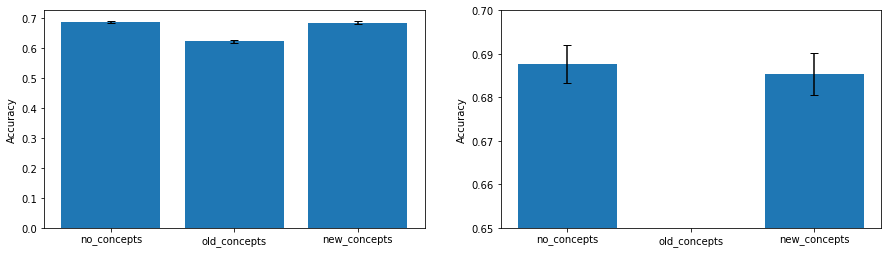

In [68]:
acc_m = []
acc_se = []
for result in [with_no_concepts, with_old_concepts, with_new_concepts]:
    # for result in [with_old_concepts, with_new_concepts]:
    acc_m.append(np.mean(result["accuracy"]))
    acc_se.append(np.std(result["accuracy"]) / math.sqrt(len(result["accuracy"])))

print(acc_m[0] - acc_m[1])
print(acc_m)
print(acc_se)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
# fig.suptitle("Accuracy comparison")
ax1.set_ylabel("Accuracy")
# ax1.bar(x=["transformer", "old_concepts", "new_concepts"],
ax1.bar(x=["no_concepts", "old_concepts", "new_concepts"],
        # ax1.bar(x=["old_concepts", "new_concepts"],
        height=acc_m,
        yerr=acc_se,
        capsize=4)
ax2.set_ylabel("Accuracy")
ax2.set_ylim(0.65, 0.7)
ax2.bar(x=["no_concepts", "old_concepts", "new_concepts"],
        # ax2.bar(x=["old_concepts", "new_concepts"],
        height=acc_m,
        yerr=acc_se,
        capsize=4)
plt.savefig('accuracy_comparison.png')

<BarContainer object of 3 artists>

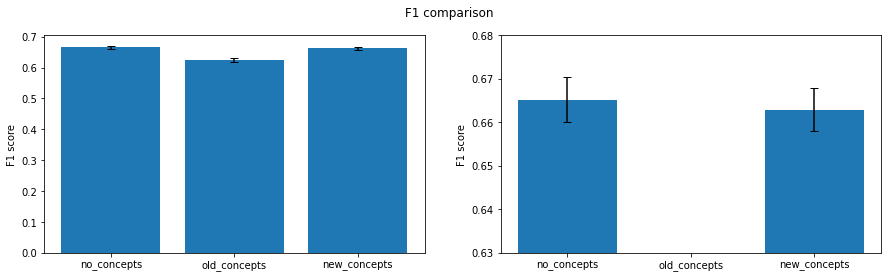

In [69]:
f1_m = []
f1_se = []
for result in [with_no_concepts, with_old_concepts, with_new_concepts]:
    # for result in [with_old_concepts, with_new_concepts]:
    f1_m.append(np.mean(result["f1"]))
    f1_se.append(np.std(result["f1"]) / math.sqrt(len(result["f1"])))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(15)
ax1.set_ylabel("F1 score")
fig.suptitle("F1 comparison")
ax1.bar(x=["no_concepts", "old_concepts", "new_concepts"],
        # ax1.bar(x=["old_concepts", "new_concepts"],
        height=f1_m,
        yerr=f1_se,
        capsize=4)
ax2.set_ylabel("F1 score")
ax2.set_ylim(0.63, 0.68)
ax2.bar(x=["no_concepts", "old_concepts", "new_concepts"],
        # ax2.bar(x=["old_concepts", "new_concepts"],
        height=f1_m,
        yerr=f1_se,
        capsize=4)

[0.16330296456597693, 0.17222549625894235]
[0.0033164952537301745, 0.0046181523017856975]


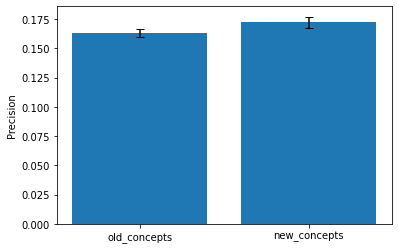

In [70]:
precision_m = []
precision_se = []
for result in [with_old_concepts, with_new_concepts]:
    precision_m.append(np.mean(result["concept_precision"]))
    precision_se.append(np.std(result["concept_precision"]) / math.sqrt(len(result["concept_precision"])))

print(precision_m)
print(precision_se)

plt.ylabel("Precision")
plt.bar(x=["old_concepts", "new_concepts"],
        height=precision_m,
        yerr=precision_se,
        capsize=4)
plt.savefig("concept_precisions.png")

In [71]:
network_type = "concept_Conv_attn"
accs = []
for model_id in with_old_concepts["model_id"]:
    model_name = model_dir + f'/best_{network_type}_{n_concepts}_{model_id}.h5'

    model = load_model(model_name)
    cf_matrix, accuracy, macro_f1, mismatch, y_pred, cf_concepts, accuracy_concepts \
        = calculate_concept_metrics(model, X_test0, y_test_binary, concept_test)

    print(accuracy)

accs = np.array(accs)
se = np.std(accs) / math.sqrt(10)

print(np.mean(accs))
print(se)



0.9452054794520548
0.9680365296803652
0.9315068493150684
0.9452054794520548
0.954337899543379
0.954337899543379
0.9315068493150684
0.954337899543379
0.9360730593607306
0.9680365296803652
nan
nan


/home/rp218/luke-for-roko/venv/lib/python3.8/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/rp218/luke-for-roko/venv/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/rp218/luke-for-roko/venv/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/rp218/luke-for-roko/venv/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/rp218/luke-for-roko/venv/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


#### Best run results

In [72]:
max_i_old_concepts = np.argmax(with_old_concepts["accuracy"])
print("Results for old concepts")
print(with_old_concepts["accuracy"][max_i_old_concepts])
print(with_old_concepts["model_id"][max_i_old_concepts])
print(with_old_concepts["f1"][max_i_old_concepts])
print(with_old_concepts["conf_mtx"][max_i_old_concepts])
print(with_old_concepts["conf_mtx_c"][max_i_old_concepts])
print(with_old_concepts["concept_acc"][max_i_old_concepts])


Results for old concepts
0.6529680365296804
1655200844
0.6532644265304494
[[20 18  4  6  1]
 [ 9 28  1  8  0]
 [ 0  0 40  0  6]
 [ 7  4  2 30  0]
 [ 0  0  9  1 25]]
[[16012   813]
 [  102   155]]
0.9464348436951177


In [73]:
max_i_new_concepts = np.argmax(with_new_concepts["accuracy"])
print("Results for old concepts")
print(with_new_concepts["accuracy"][max_i_new_concepts])
print(with_new_concepts["model_id"][max_i_new_concepts])
print(with_new_concepts["f1"][max_i_new_concepts])
print(with_new_concepts["conf_mtx"][max_i_new_concepts])
print(with_new_concepts["conf_mtx_c"][max_i_new_concepts])
print(with_new_concepts["concept_acc"][max_i_new_concepts])

Results for old concepts
0.7077625570776256
1655196803
0.6862550405403518
[[18 16  1  7  0]
 [ 7 31  0 10  0]
 [ 0  0 59  0  3]
 [ 4  6  0 24  3]
 [ 0  1  5  1 23]]
[[15831   872]
 [  193   186]]
0.9376536705303828


## Visualising predictions

In [84]:
from nn.utils import visualize_concepts

# print(labels.index[labels['id'] == 'WSYKJR5QCQ5K'].tolist())

curr_point = 118
# network_type = "image_classifier_network"
network_type = 'concept_Conv_attn'
# X_visualize = X_birds_data[curr_point]
X_visualize = X_test0[curr_point]
# y_true = birds_inv_class_dict[y_birds_data[curr_point].numpy()]

y_true = inv_class_dict[np.argmax(y_test_binary[curr_point])]
curr_id = id_test0[122]
print(curr_id)
print(f"The video id we are observing is {curr_id}")
# print(f"The image id we are observing is {birds_img_ids[curr_point]}")
print(concepts_text.shape)
print(y_true)

SAGXX461QCAB
The video id we are observing is SAGXX461QCAB
(78,)
play


1655200844
True label is: play
Predicted Concepts: [ 3 21]
Predicted Class: play
Predicted concept text before attention: ['the batter did not swing' 'he hit it']
Scores before attention [0.97922397 0.89675415]
We have 2 values that are close to the maximum
top 2 values after attention: [0.08108414 0.08106694]
top 2 after attention: ['the batter did not swing' 'he hit it']


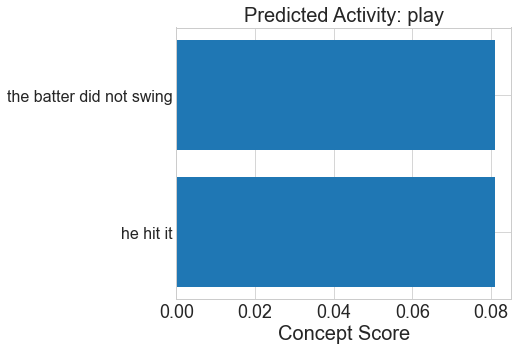

In [91]:
#Load BEST Trained Model
model_id = with_old_concepts["model_id"][max_i_old_concepts]
print(model_id)
model = load_model(
    model_dir + f'/best_{network_type}_{n_concepts}_{model_id}.h5')
print(f"True label is: {y_true}")
save_name = 'predicted_old_concepts.png'
pred, pred_label, pred_concepts, pred_attn = visualize_concepts(X_visualize, model,
                                                                old_concepts_text, inv_class_dict,
                                                                save_name)

['1655195211', '1655195642', '1655196032', '1655196419', '1655196803', '1655197228', '1655197609', '1655197990', '1655198373', '1655198758']
True label is: play
Predicted Concepts: [ 2  3  4  7 15 18]
Predicted Class: play
Predicted concept text before attention: ['The batter hit the ball.' 'It was caught.'
 'The batter hit the ball in the air.'
 'The batter hit the ball on the ground.' 'The ball was hit.'
 'The batter hit a ground ball.']
Scores before attention [0.8903129  0.75522506 0.86695504 0.8009516  0.77557564 0.7407367 ]
We have 6 values that are close to the maximum
top 6 values after attention: [0.06350921 0.06350506 0.06348356 0.06347112 0.06338616 0.06328099]
top 6 after attention: ['The batter hit the ball in the air.' 'The batter hit a ground ball.'
 'It was caught.' 'The batter hit the ball on the ground.'
 'The ball was hit.' 'The batter hit the ball.']


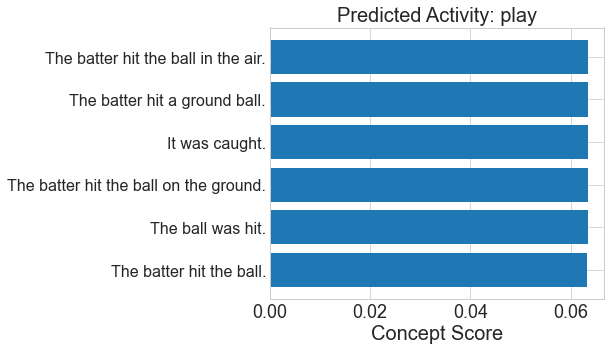

In [92]:
#Load BEST Trained Model
model_id = with_new_concepts["model_id"][max_i_new_concepts]
print(with_new_concepts["model_id"])
model = load_model(
    model_dir + f'/best_{network_type}_{n_concepts}_{model_id}.h5')
print(f"True label is: {y_true}")
save_name = 'predicted_new_concepts.png'
pred, pred_label, pred_concepts, pred_attn = visualize_concepts(X_visualize, model,
                                                                concepts_text, inv_class_dict,
                                                                save_name)


### Vikranth's results

In [93]:
indices = [15, 30, 50, 78, 100, 200]
mean_a = [0.6169, 0.6389, 0.6437, 0.66133, 0.6614, 0.6610]
std_a = [0.0082, 0.0166, 0.0177, 0.00716, 0.0028, 0.0037]
mean_f = [0.6145, 0.6452, 0.64715, 0.6632, 0.6639, 0.6645]
std_f = [0.0126, 0.01769, 0.0134, 0.00676, 0.0049, 0.0042]

In [94]:
plt.style.use('seaborn-whitegrid')

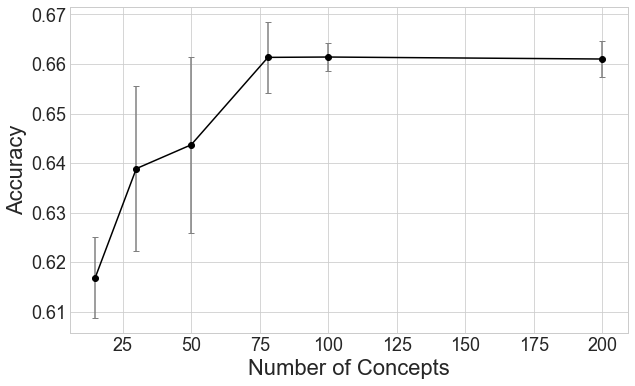

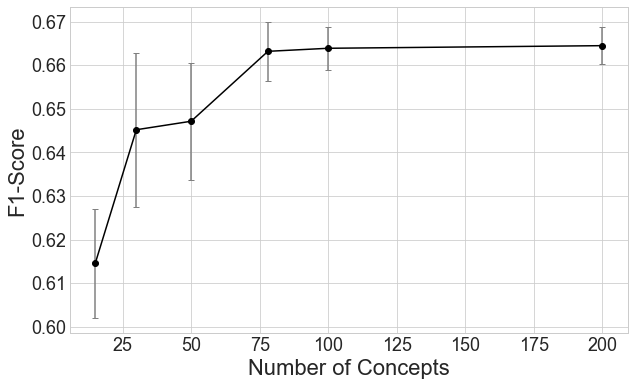

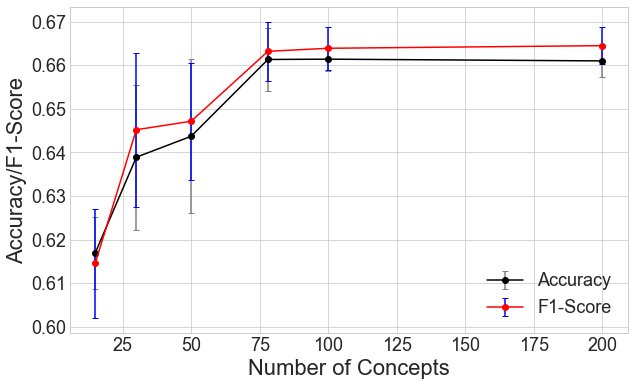

In [95]:
plt.figure(figsize=(10, 6))
plt.errorbar(indices, mean_a, yerr=std_a, fmt='-ok', ecolor='gray', capsize=3);
# plt.ylim([0.5,0.75])
# plt.xticks(fontsize=14, rotation=90)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of Concepts', fontsize=22)
plt.ylabel('Accuracy', fontsize=22)
# plt.savefig('Accuracy')
plt.show()

plt.figure(figsize=(10, 6))
plt.errorbar(indices, mean_f, yerr=std_f, fmt='-ok', ecolor='gray', capsize=3);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of Concepts', fontsize=22)
plt.ylabel('F1-Score', fontsize=22)
# plt.savefig('F1_score')
plt.show()

plt.figure(figsize=(10, 6))
plt.errorbar(indices, mean_a, yerr=std_a, fmt='-ok', ecolor='gray', capsize=3);
plt.errorbar(indices, mean_f, yerr=std_f, fmt='-or', ecolor='blue', capsize=3);
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel('Number of Concepts', fontsize=22)
plt.ylabel('Accuracy/F1-Score', fontsize=22)
plt.legend(['Accuracy', 'F1-Score'], fontsize=18, loc=4)
# plt.savefig('both')
plt.show()